In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import scipy as sp
import os
from scipy.linalg import fractional_matrix_power

from jax import vmap, jit, numpy as jnp, random, lax, jvp, scipy as jsp
import matplotlib.pyplot as plt
import pickle
from functools import reduce

import matplotlib.animation as animation
from IPython.display import HTML

module_path = os.path.abspath(os.path.join("/Users/shufay/Documents/ad_afqmc"))
if module_path not in sys.path:
    sys.path.append(module_path)

from ad_afqmc import (
    driver,
    pyscf_interface,
    mpi_jax,
    linalg_utils,
    lattices,
    propagation,
    wavefunctions,
    hamiltonian,
    hf_guess
)

from pyscf import fci, gto, scf, mp, ao2mo

import itertools
from functools import partial

np.set_printoptions(precision=5, suppress=True)

# Hostname: Shus-MacBook-Pro-7.local
# System Type: Darwin
# Machine Type: x86_64
# Processor: i386


In [4]:
@jit
def calc_s2(sd_up, sd_dn):
    green_up = (
        sd_up.dot(jnp.linalg.inv(sd_up.T.conj().dot(sd_up))).dot(sd_up.T.conj())
    ).T
    green_dn = (
        sd_dn.dot(jnp.linalg.inv(sd_dn.T.conj().dot(sd_dn))).dot(sd_dn.T.conj())
    ).T
    spsm = sd_up.shape[1] - jnp.trace(green_up.dot(green_dn))
    sz = (sd_up.shape[1] - sd_dn.shape[1]) / 2
    return spsm + sz * (sz - 1)


@jit
def calc_green(sd):
    return (sd.dot(jnp.linalg.inv(sd.T.conj().dot(sd))).dot(sd.T.conj())).T


@jit
def calc_norm(sd):
    return jnp.linalg.det(sd.T.conj().dot(sd))

In [5]:
@jit
def normalize(walker):
    walker = vmap(lambda x: x / jnp.linalg.norm(x), in_axes=1, out_axes=1)(walker)
    return walker

In [6]:
@partial(jit, static_argnums=(3,))
def ham_element_hubbard(x, y, u, lattice):
    n_sites = lattice.n_sites
    n_elec = jnp.array((jnp.sum(x[0]), jnp.sum(x[1])))
    diff = jnp.array((jnp.bitwise_xor(x[0], y[0]), jnp.bitwise_xor(x[1], y[1])))
    diff_count = jnp.array((jnp.sum(diff[0]), jnp.sum(diff[1])))
    on_site = (jnp.sum(diff_count) == 0) * u * jnp.bitwise_and(x[0], x[1]).sum()
    diff_pos = jnp.nonzero(diff, size=2)
    site_1 = diff_pos[1][0]
    site_2 = diff_pos[1][1]
    hopping = (jnp.sum(diff_count) == 2) * (
        (site_2 - site_1 == 1) * -1.0
        + (site_2 - site_1 == n_sites - 1)
        * (-1.0) ** (1 + jnp.sum((n_elec - 1) * diff_count / 2))
    )
    return on_site + hopping


def make_basis_spin(n_sites, n_elec):
    # generate permutations using lexicographic order
    basis = []
    elec = np.zeros(n_sites)
    for i in range(n_elec):
        elec[-i - 1] = 1
    basis.append(elec.copy())
    # find next permutation
    while True:
        k = -1
        for i in range(n_sites - 1):
            if elec[i] < elec[i + 1]:
                k = i
        if k == -1:
            break
        l = k
        for i in range(k + 1, n_sites):
            if elec[k] < elec[i]:
                l = i
        elec[k], elec[l] = elec[l], elec[k]
        elec[k + 1 :] = np.flip(elec[k + 1 :])
        basis.append(elec.copy())
    return np.array(basis, dtype=int)


def make_basis(n_sites, n_elec: tuple):
    basis_up = make_basis_spin(n_sites, n_elec[0])
    if n_elec[0] == n_elec[1]:
        basis_down = basis_up
    else:
        basis_down = make_basis_spin(n_sites, n_elec[1])
    basis = itertools.product(basis_up, basis_down)
    return np.array(list(basis))

In [7]:
n_sites = 4
n_elec = (2, 2)
u = 4.0
lattice = lattices.one_dimensional_chain(n_sites)
ci_basis = jnp.array(make_basis(n_sites, n_elec), dtype=jnp.int32)
print(f"built basis, length: {len(ci_basis)}")
ham_element = partial(ham_element_hubbard, u=u, lattice=lattice)
ham_mat = vmap(vmap(ham_element, (None, 0)), (0, None))(ci_basis, ci_basis)
print("built hamiltonian")
ene_mat, vec = jnp.linalg.eigh(ham_mat)
print(ene_mat[:10])

I0000 00:00:1730297365.985300 1214704 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


built basis, length: 36
built hamiltonian
[-2.10275 -1.80642 -1.06814 -0.82843 -0.82843 -0.       0.58145  2.
  2.       2.     ]


## 2D Hubbard CPMC


### Square lattice (UHF trial)


In [ ]:
lattice = lattices.two_dimensional_grid(4, 4)
# lattice = lattices.one_dimensional_chain(6)
n_sites = lattice.n_sites
u = 4.0
n_elec = (8, 8)

np.random.seed(0)

integrals = {}
integrals["h0"] = 0.0

h1 = -1.0 * lattice.create_adjacency_matrix()
integrals["h1"] = h1

h2 = np.zeros((n_sites, n_sites, n_sites, n_sites))
for i in range(n_sites):
    h2[i, i, i, i] = u
integrals["h2"] = ao2mo.restore(8, h2, n_sites)

# make dummy molecule
mol = gto.Mole()
mol.nelectron = sum(n_elec)
mol.incore_anyway = True
mol.spin = abs(n_elec[0] - n_elec[1])
mol.build()

mf = scf.RHF(mol)
mf.get_hcore = lambda *args: integrals["h1"]
mf.get_ovlp = lambda *args: np.eye(n_sites)
mf._eri = ao2mo.restore(8, integrals["h2"], n_sites)
mf.kernel()

np.random.seed(0)

umf = scf.UHF(mol)
umf.get_hcore = lambda *args: integrals["h1"]
umf.get_ovlp = lambda *args: np.eye(n_sites)
umf._eri = ao2mo.restore(8, integrals["h2"], n_sites)
dm_init = 1.0 * umf.init_guess_by_1e()
# for i in range(n_sites // 2):
#     dm_init[0, 2 * i, 2 * i] = 1.0
#     dm_init[1, 2 * i + 1, 2 * i + 1] = 1.0
dm_init += 1.0 * np.random.randn(*dm_init.shape)
umf.kernel(dm_init)
mo1 = umf.stability()[0]
umf = umf.newton().run(mo1, umf.mo_occ)
mo1 = umf.stability()[0]
umf = umf.newton().run(mo1, umf.mo_occ)
mo1 = umf.stability()[0]
umf = umf.newton().run(mo1, umf.mo_occ)
umf.stability()

# rotate uhf to x axis to get ghf
gmf_coeff = np.zeros((2 * n_sites, n_elec[0] + n_elec[1]))
theta = np.pi / 4
gmf_coeff[:n_sites, : n_elec[0]] = np.cos(theta) * umf.mo_coeff[0][:, : n_elec[0]]
gmf_coeff[n_sites:, : n_elec[0]] = np.sin(theta) * umf.mo_coeff[0][:, : n_elec[0]]
gmf_coeff[:n_sites, n_elec[0] :] = np.sin(-theta) * umf.mo_coeff[1][:, : n_elec[1]]
gmf_coeff[n_sites:, n_elec[0] :] = np.cos(-theta) * umf.mo_coeff[1][:, : n_elec[1]]

# fci
if sum(n_elec) < 8:
    ci = fci.FCI(mol)
    e, ci_coeffs = ci.kernel(
        h1e=integrals["h1"], eri=integrals["h2"], norb=n_sites, nelec=n_elec
    )
    print(f"fci energy: {e}")

# ad afqmc
pyscf_interface.prep_afqmc(umf, basis_coeff=np.eye(n_sites), integrals=integrals)
options = {
    "dt": 0.005,
    "n_eql": 5,
    "n_ene_blocks": 1,
    "n_sr_blocks": 5,
    "n_blocks": 100,
    "n_prop_steps": 50,
    "n_walkers": 50,
    "seed": 98,
    "walker_type": "uhf",
    "trial": "uhf",
    "save_walkers": False,
}

ham_data, ham, prop, trial, wave_data, sampler, observable, options, MPI = (
    mpi_jax._prep_afqmc(options)
)

# comment out this block for doing ph-afqmc
prop = propagation.propagator_cpmc(
    dt=options["dt"],
    n_walkers=options["n_walkers"],
)
trial = wavefunctions.ghf_cpmc(n_sites, n_elec)
ham_data["u"] = u
# wave_data["mo_coeff"] = [
#     umf.mo_coeff[0][:, : n_elec[0]],
#     umf.mo_coeff[1][:, : n_elec[1]],
# ]
wave_data["mo_coeff"] = gmf_coeff[:, : n_elec[0] + n_elec[1]]

e_afqmc, err_afqmc = driver.afqmc(
    ham_data, ham, prop, trial, wave_data, sampler, observable, options, MPI
)

### Nearest neighbor interactions


In [ ]:
lattice = lattices.two_dimensional_grid(4, 4)
n_sites = lattice.n_sites
u = 4.0
u_1 = 0.0
n_elec = (8, 8)

np.random.seed(0)

integrals = {}
integrals["h0"] = 0.0

h1 = -1.0 * lattice.create_adjacency_matrix()
integrals["h1"] = h1

h2 = np.zeros((n_sites, n_sites, n_sites, n_sites))
neighbors = set()
for i in range(n_sites):
    h2[i, i, i, i] = u
    site_i = lattice.sites[i]
    for site_j in lattice.get_nearest_neighbors(site_i):
        j = int(lattice.get_site_num(site_j))
        h2[i, i, j, j] = u_1
        h2[j, j, i, i] = u_1
        if i < j:
            neighbors.add((i, j))
neighbors = tuple(neighbors)
integrals["h2"] = ao2mo.restore(8, h2, n_sites)

# make dummy molecule
mol = gto.Mole()
mol.nelectron = sum(n_elec)
mol.incore_anyway = True
mol.spin = abs(n_elec[0] - n_elec[1])
mol.build()

mf = scf.RHF(mol)
mf.get_hcore = lambda *args: integrals["h1"]
mf.get_ovlp = lambda *args: np.eye(n_sites)
mf._eri = ao2mo.restore(8, integrals["h2"], n_sites)
mf.kernel()

np.random.seed(0)

umf = scf.UHF(mol)
umf.get_hcore = lambda *args: integrals["h1"]
umf.get_ovlp = lambda *args: np.eye(n_sites)
umf._eri = ao2mo.restore(8, integrals["h2"], n_sites)
dm_init = 1.0 * umf.init_guess_by_1e()
# for i in range(n_sites // 2):
#     dm_init[0, 2 * i, 2 * i] = 1.0
#     dm_init[1, 2 * i + 1, 2 * i + 1] = 1.0
dm_init += 1.0 * np.random.randn(*dm_init.shape)
umf.kernel(dm_init)
mo1 = umf.stability()[0]
umf = umf.newton().run(mo1, umf.mo_occ)
mo1 = umf.stability()[0]
umf = umf.newton().run(mo1, umf.mo_occ)
umf.stability()

# rotate uhf to x axis to get ghf
gmf_coeff = np.zeros((2 * n_sites, n_elec[0] + n_elec[1]))
gmf_coeff[:n_sites, : n_elec[0]] = umf.mo_coeff[0][:, : n_elec[0]] / 2**0.5
gmf_coeff[n_sites:, : n_elec[0]] = umf.mo_coeff[0][:, : n_elec[0]] / 2**0.5
gmf_coeff[:n_sites, n_elec[0] :] = umf.mo_coeff[1][:, : n_elec[1]] / 2**0.5
gmf_coeff[n_sites:, n_elec[0] :] = -umf.mo_coeff[1][:, : n_elec[1]] / 2**0.5

# fci
if sum(n_elec) < 8:
    ci = fci.FCI(mol)
    e, ci_coeffs = ci.kernel(
        h1e=integrals["h1"], eri=integrals["h2"], norb=n_sites, nelec=n_elec
    )
    print(f"fci energy: {e}")

# ad afqmc
pyscf_interface.prep_afqmc(umf, basis_coeff=np.eye(n_sites), integrals=integrals)
options = {
    "dt": 0.005,
    "n_eql": 5,
    "n_ene_blocks": 1,
    "n_sr_blocks": 5,
    "n_blocks": 100,
    "n_prop_steps": 50,
    "n_walkers": 50,
    "seed": 98,
    "walker_type": "uhf",
    "save_walkers": True,
}

ham_data, ham, prop, trial, wave_data, sampler, observable, options, MPI = (
    mpi_jax._prep_afqmc(options)
)

# comment out this block for doing ph-afqmc
prop = propagation.propagator_cpmc_nn(
    dt=options["dt"],
    n_walkers=options["n_walkers"],
    neighbors=neighbors,
)
trial = wavefunctions.ghf_cpmc(n_sites, n_elec)
wave_data["mo_coeff"] = gmf_coeff[:, : n_elec[0] + n_elec[1]]
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)
ham_data["u"] = u
ham_data["u_1"] = u_1

e_afqmc, err_afqmc = driver.afqmc(
    ham_data, ham, prop, trial, wave_data, sampler, observable, options, MPI
)

### Triangular lattice (GHF trial)


In [9]:
lattice = lattices.triangular_grid(6, 6, open_x=True)
n_sites = lattice.n_sites
u = 6.0
n_elec = (18, 18)

integrals = {}
integrals["h0"] = 0.0

h1 = -1.0 * lattice.create_adjacency_matrix()
integrals["h1"] = h1

h2 = np.zeros((n_sites, n_sites, n_sites, n_sites))
for i in range(n_sites):
    h2[i, i, i, i] = u
integrals["h2"] = ao2mo.restore(8, h2, n_sites)

# make dummy molecule
mol = gto.Mole()
mol.nelectron = sum(n_elec)
mol.incore_anyway = True
mol.spin = abs(n_elec[0] - n_elec[1])
mol.build()

mf = scf.RHF(mol)
mf.get_hcore = lambda *args: integrals["h1"]
mf.get_ovlp = lambda *args: np.eye(n_sites)
mf._eri = ao2mo.restore(8, integrals["h2"], n_sites)
mf.kernel()

umf = scf.UHF(mol)
umf.get_hcore = lambda *args: integrals["h1"]
umf.get_ovlp = lambda *args: np.eye(n_sites)
umf._eri = ao2mo.restore(8, integrals["h2"], n_sites)
dm_init = 1.0 * umf.init_guess_by_1e()
# for i in range(n_sites // 2):
#     dm_init[0, 2 * i, 2 * i] = 1.0
#     dm_init[1, 2 * i + 1, 2 * i + 1] = 1.0
dm_init += 1.0 * np.random.randn(*dm_init.shape)
umf.kernel(dm_init)
mo1 = umf.stability()[0]
umf = umf.newton().run(mo1, umf.mo_occ)
mo1 = umf.stability()[0]
umf = umf.newton().run(mo1, umf.mo_occ)
umf.stability()

# ghf
gmf = scf.GHF(mol)
gmf.get_hcore = lambda *args: sp.linalg.block_diag(integrals["h1"], integrals["h1"])
gmf.get_ovlp = lambda *args: np.eye(2 * n_sites)
gmf._eri = ao2mo.restore(8, integrals["h2"], n_sites)
dm_init = sp.linalg.block_diag(dm_init[0], dm_init[1])
dm_init += 2.0 * np.random.randn(*dm_init.shape)
gmf.kernel(dm_init)
mo1 = gmf.stability(external=True)
gmf = gmf.newton().run(mo1, gmf.mo_occ)
mo1 = gmf.stability(external=True)
gmf = gmf.newton().run(mo1, gmf.mo_occ)
mo1 = gmf.stability(external=True)
gmf = gmf.newton().run(mo1, gmf.mo_occ)

# fci
if sum(n_elec) < 8:
    ci = fci.FCI(mol)
    e, ci_coeffs = ci.kernel(
        h1e=integrals["h1"], eri=integrals["h2"], norb=n_sites, nelec=n_elec
    )
    print(f"fci energy: {e}")

# ad afqmc
pyscf_interface.prep_afqmc(umf, basis_coeff=np.eye(n_sites), integrals=integrals)
options = {
    "dt": 0.005,
    "n_eql": 5,
    "n_ene_blocks": 1,
    "n_sr_blocks": 5,
    "n_blocks": 100,
    "n_prop_steps": 50,
    "n_walkers": 50,
    "seed": 98,
    "walker_type": "uhf",
    # "trial": "uhf",
    "save_walkers": False,
}

ham_data, ham, prop, trial, wave_data, sampler, observable, options, MPI = (
    mpi_jax._prep_afqmc(options)
)

# trial = wavefunctions.ghf(n_sites, n_elec)
prop = propagation.propagator_cpmc(dt=options["dt"], n_walkers=options["n_walkers"])
trial = wavefunctions.ghf_cpmc(n_sites, n_elec)
wave_data["mo_coeff"] = gmf.mo_coeff[:, : n_elec[0] + n_elec[1]]
rdm1 = gmf.make_rdm1()
wave_data["rdm1"] = jnp.array([rdm1[:n_sites, :n_sites], rdm1[n_sites:, n_sites:]])
gamma = np.arccosh(np.exp(prop.dt * u / 2))
const = jnp.exp(-prop.dt * u / 2)
ham_data["hs_constant"] = const * jnp.array(
    [[jnp.exp(gamma), jnp.exp(-gamma)], [jnp.exp(-gamma), jnp.exp(gamma)]]
)
ham_data["u"] = u

e_afqmc, err_afqmc = driver.afqmc(
    ham_data, ham, prop, trial, wave_data, sampler, observable, options, MPI
)

SCF not converged.
SCF energy = -11.5785242106505
SCF not converged.
SCF energy = -18.7591627844047 after 50 cycles  <S^2> = 11.768229  2S+1 = 6.9334634
<class 'pyscf.scf.uhf.UHF'> wavefunction has an internal instability
converged SCF energy = -19.0562177541396  <S^2> = 12.451564  2S+1 = 7.1278508
<class 'pyscf.soscf.newton_ah.SecondOrderUHF'> wavefunction is stable in the internal stability analysis
converged SCF energy = -19.0562177541516  <S^2> = 12.451566  2S+1 = 7.1278512
<class 'pyscf.soscf.newton_ah.SecondOrderUHF'> wavefunction is stable in the internal stability analysis
SCF not converged.
SCF energy = -20.7634489378676 after 50 cycles  <S^2> = 13.594397  2S+1 = 7.441612
<class 'pyscf.scf.ghf.GHF'> wavefunction has an internal instability
converged SCF energy = -21.2122963082281  <S^2> = 13.952911  2S+1 = 7.5373498
<class 'pyscf.soscf.newton_ah.SecondOrderGHF'> wavefunction is stable in the internal stability analysis
converged SCF energy = -21.2122963082547  <S^2> = 13.95291

### Triangular lattice (GHF Neel trial)

In [3]:
lattice = lattices.triangular_grid(6, 6, open_x=True)
n_sites = lattice.n_sites
u = 6.0
n_elec = (18, 18)
nocc = sum(n_elec)

integrals = {}
integrals["h0"] = 0.0

h1 = -1.0 * lattice.create_adjacency_matrix()
integrals["h1"] = h1

h2 = np.zeros((n_sites, n_sites, n_sites, n_sites))
for i in range(n_sites):
    h2[i, i, i, i] = u
integrals["h2"] = ao2mo.restore(8, h2, n_sites)

# make dummy molecule
mol = gto.Mole()
mol.nelectron = nocc
mol.incore_anyway = True
mol.spin = abs(n_elec[0] - n_elec[1])
mol.build()

# uhf
umf = scf.UHF(mol)
umf.get_hcore = lambda *args: integrals["h1"]
umf.get_ovlp = lambda *args: np.eye(n_sites)
umf._eri = ao2mo.restore(8, integrals["h2"], n_sites)
dm_init = 1.0 * umf.init_guess_by_1e()
# for i in range(n_sites // 2):
#     dm_init[0, 2 * i, 2 * i] = 1.0
#     dm_init[1, 2 * i + 1, 2 * i + 1] = 1.0
dm_init += 1.0 * np.random.randn(*dm_init.shape)
umf.kernel(dm_init)
mo1 = umf.stability()[0]
umf = umf.newton().run(mo1, umf.mo_occ)
mo1 = umf.stability()[0]
umf = umf.newton().run(mo1, umf.mo_occ)
umf.stability()

# ghf
gmf = scf.GHF(mol)
gmf.get_hcore = lambda *args: sp.linalg.block_diag(integrals["h1"], integrals["h1"])
gmf.get_ovlp = lambda *args: np.eye(2 * n_sites)
gmf._eri = ao2mo.restore(8, integrals["h2"], n_sites)

# costruct Neel guess.
occ = np.ones(2*n_sites)
occ[:nocc] = 1
psi0 = hf_guess.get_ghf_neel_guess(lattice)
dm_init = psi0 @ np.diag(occ) @ psi0.T.conj()

gmf.kernel(dm_init)
mo1 = gmf.stability(external=True)
gmf = gmf.newton().run(mo1, gmf.mo_occ)
mo1 = gmf.stability(external=True)
gmf = gmf.newton().run(mo1, gmf.mo_occ)
mo1 = gmf.stability(external=True)
gmf = gmf.newton().run(mo1, gmf.mo_occ)

Overwritten attributes  get_ovlp get_hcore  of <class 'pyscf.scf.uhf.UHF'>


SCF not converged.
SCF energy = -16.8038790933498 after 50 cycles  <S^2> = 10.062298  2S+1 = 6.4225535
<class 'pyscf.scf.uhf.UHF'> wavefunction has an internal instability.
converged SCF energy = -18.5363282551274  <S^2> = 12.473729  2S+1 = 7.1340674


Overwritten attributes  get_ovlp get_hcore  of <class 'pyscf.soscf.newton_ah.SecondOrderUHF'>


<class 'pyscf.soscf.newton_ah.SecondOrderUHF'> wavefunction is stable in the internal stability analysis
converged SCF energy = -18.536328255138  <S^2> = 12.47373  2S+1 = 7.1340676
<class 'pyscf.soscf.newton_ah.SecondOrderUHF'> wavefunction is stable in the internal stability analysis


Overwritten attributes  get_ovlp get_hcore  of <class 'pyscf.scf.ghf.GHF'>


converged SCF energy = -21.29002573553  <S^2> = 14.535516  2S+1 = 7.6903877
<class 'pyscf.scf.ghf.GHF'> wavefunction is stable in the internal stability analysis
converged SCF energy = -21.2900257383165  <S^2> = 14.535402  2S+1 = 7.6903582
<class 'pyscf.soscf.newton_ah.SecondOrderGHF'> wavefunction is stable in the internal stability analysis
converged SCF energy = -21.2900257385291  <S^2> = 14.535351  2S+1 = 7.6903448


Overwritten attributes  get_ovlp get_hcore  of <class 'pyscf.soscf.newton_ah.SecondOrderGHF'>


<class 'pyscf.soscf.newton_ah.SecondOrderGHF'> wavefunction is stable in the internal stability analysis
converged SCF energy = -21.2900257385591  <S^2> = 14.535355  2S+1 = 7.690346


In [4]:
from ad_afqmc.spin_utils import get_ao_spin_average

Sx, Sy, Sz = get_ao_spin_average(psi0, gmf.mo_occ)
spin = np.array(list(zip(Sx, Sz)))

sites = lattice.sites
coords = np.array([lattice.get_site_coordinate(site) for site in sites])

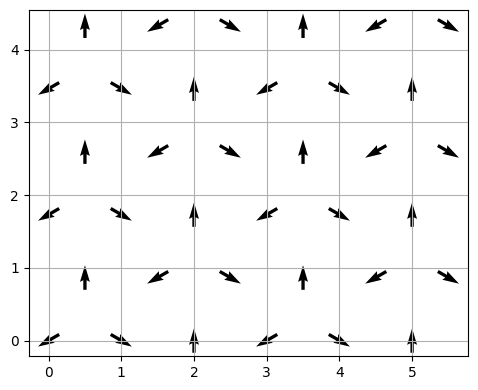

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
fac = 0.5

# ax.scatter(coords[:, 0], coords[:, 1])
ax.quiver(coords[:, 0], coords[:, 1], spin[:n_sites, 0], spin[:n_sites, 1], pivot='mid')
    
ax.grid()
ax.set_aspect('equal')
plt.tight_layout()

In [6]:
from ad_afqmc.spin_utils import get_ao_spin_average

Sx, Sy, Sz = get_ao_spin_average(gmf.mo_coeff, gmf.mo_occ)
spin = np.array(list(zip(Sx, Sz)))

sites = lattice.sites
coords = np.array([lattice.get_site_coordinate(site) for site in sites])

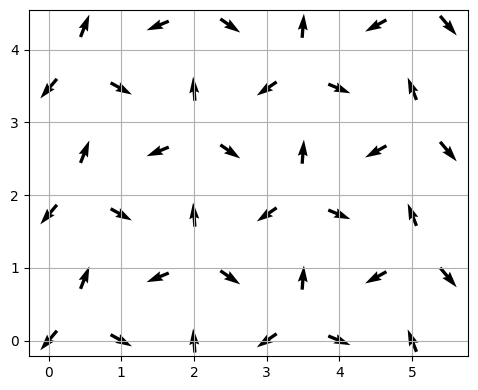

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
fac = 0.5

# ax.scatter(coords[:, 0], coords[:, 1])
ax.quiver(coords[:, 0], coords[:, 1], spin[:n_sites, 0], spin[:n_sites, 1], pivot='mid')
    
ax.grid()
ax.set_aspect('equal')
plt.tight_layout()

In [ ]:
# fci
if sum(n_elec) < 8:
    ci = fci.FCI(mol)
    e, ci_coeffs = ci.kernel(
        h1e=integrals["h1"], eri=integrals["h2"], norb=n_sites, nelec=n_elec
    )
    print(f"fci energy: {e}")

# ad afqmc
pyscf_interface.prep_afqmc(umf, basis_coeff=np.eye(n_sites), integrals=integrals)
options = {
    "dt": 0.005,
    "n_eql": 5,
    "n_ene_blocks": 1,
    "n_sr_blocks": 5,
    "n_blocks": 100,
    "n_prop_steps": 50,
    "n_walkers": 50,
    "seed": 98,
    "walker_type": "uhf",
    # "trial": "uhf",
    "save_walkers": False,
}

ham_data, ham, prop, trial, wave_data, sampler, observable, options, MPI = (
    mpi_jax._prep_afqmc(options)
)

# trial = wavefunctions.ghf(n_sites, n_elec)
prop = propagation.propagator_cpmc(dt=options["dt"], n_walkers=options["n_walkers"])
trial = wavefunctions.ghf_cpmc(n_sites, n_elec)
wave_data["mo_coeff"] = gmf.mo_coeff[:, : n_elec[0] + n_elec[1]]
rdm1 = gmf.make_rdm1()
wave_data["rdm1"] = jnp.array([rdm1[:n_sites, :n_sites], rdm1[n_sites:, n_sites:]])
gamma = np.arccosh(np.exp(prop.dt * u / 2))
const = jnp.exp(-prop.dt * u / 2)
ham_data["hs_constant"] = const * jnp.array(
    [[jnp.exp(gamma), jnp.exp(-gamma)], [jnp.exp(-gamma), jnp.exp(gamma)]]
)
ham_data["u"] = u

e_afqmc, err_afqmc = driver.afqmc(
    ham_data, ham, prop, trial, wave_data, sampler, observable, options, MPI
)

#
# Preparing AFQMC calculation
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (18, 18)
# Number of basis functions: 36
# Number of Cholesky vectors: 36
#
# Number of MPI ranks: 1
#
# No trial specified in options.
# trial.pkl not found, make sure to construct the trial separately.
# norb: 36
# nelec: (18, 18)
#
# dt: 0.005
# n_eql: 5
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 100
# n_prop_steps: 50
# n_walkers: 50
# seed: 98
# walker_type: uhf
# save_walkers: False
# n_ene_blocks_eql: 5
# n_sr_blocks_eql: 10
# orbital_rotation: True
# do_sr: True
# symmetry: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
#
# Equilibration sweeps:
#   Iter        Block energy      Walltime
#     0      -2.186473104e+01     1.24e+00 


### Triangular lattice (AFM stripe trial)

In [8]:
lattice = lattices.triangular_grid(6, 6, open_x=True)
n_sites = lattice.n_sites
u = 6.0
n_elec = (18, 18)
nocc = sum(n_elec)

integrals = {}
integrals["h0"] = 0.0

h1 = -1.0 * lattice.create_adjacency_matrix()
integrals["h1"] = h1

h2 = np.zeros((n_sites, n_sites, n_sites, n_sites))
for i in range(n_sites):
    h2[i, i, i, i] = u
integrals["h2"] = ao2mo.restore(8, h2, n_sites)

# make dummy molecule
mol = gto.Mole()
mol.nelectron = nocc
mol.incore_anyway = True
mol.spin = abs(n_elec[0] - n_elec[1])
mol.build()

# uhf
umf = scf.UHF(mol)
umf.get_hcore = lambda *args: integrals["h1"]
umf.get_ovlp = lambda *args: np.eye(n_sites)
umf._eri = ao2mo.restore(8, integrals["h2"], n_sites)
dm_init = 1.0 * umf.init_guess_by_1e()
# for i in range(n_sites // 2):
#     dm_init[0, 2 * i, 2 * i] = 1.0
#     dm_init[1, 2 * i + 1, 2 * i + 1] = 1.0
dm_init += 1.0 * np.random.randn(*dm_init.shape)
umf.kernel(dm_init)
mo1 = umf.stability()[0]
umf = umf.newton().run(mo1, umf.mo_occ)
mo1 = umf.stability()[0]
umf = umf.newton().run(mo1, umf.mo_occ)
umf.stability()

# ghf
gmf = scf.GHF(mol)
gmf.get_hcore = lambda *args: sp.linalg.block_diag(integrals["h1"], integrals["h1"])
gmf.get_ovlp = lambda *args: np.eye(2 * n_sites)
gmf._eri = ao2mo.restore(8, integrals["h2"], n_sites)

# costruct Neel guess.
occ = np.ones(2*n_sites)
occ[:nocc] = 1
psi0 = hf_guess.get_afm_stripe_guess(lattice)
dm_init = psi0 @ np.diag(occ) @ psi0.T.conj()

gmf.kernel(dm_init)
mo1 = gmf.stability(external=True)
gmf = gmf.newton().run(mo1, gmf.mo_occ)
mo1 = gmf.stability(external=True)
gmf = gmf.newton().run(mo1, gmf.mo_occ)
mo1 = gmf.stability(external=True)
gmf = gmf.newton().run(mo1, gmf.mo_occ)

converged SCF energy = -17.8311999825247  <S^2> = 10.960519  2S+1 = 6.6964228
<class 'pyscf.scf.uhf.UHF'> wavefunction has an internal instability.
converged SCF energy = -18.6389109347974  <S^2> = 12.326793  2S+1 = 7.0927549
<class 'pyscf.soscf.newton_ah.SecondOrderUHF'> wavefunction is stable in the internal stability analysis
converged SCF energy = -18.63891093481  <S^2> = 12.326792  2S+1 = 7.0927545
<class 'pyscf.soscf.newton_ah.SecondOrderUHF'> wavefunction is stable in the internal stability analysis
converged SCF energy = -19.8667887883658  <S^2> = 12.240572  2S+1 = 7.0684006
<class 'pyscf.scf.ghf.GHF'> wavefunction is stable in the internal stability analysis
converged SCF energy = -19.8667887883665  <S^2> = 12.240571  2S+1 = 7.0684004
<class 'pyscf.soscf.newton_ah.SecondOrderGHF'> wavefunction has an internal instability
converged SCF energy = -21.2110907341349  <S^2> = 13.839457  2S+1 = 7.5071851
<class 'pyscf.soscf.newton_ah.SecondOrderGHF'> wavefunction is stable in the int

In [9]:
from ad_afqmc.spin_utils import get_ao_spin_average

Sx, Sy, Sz = get_ao_spin_average(psi0, gmf.mo_occ)
spin = np.array(list(zip(Sx, Sz)))

sites = lattice.sites
coords = np.array([lattice.get_site_coordinate(site) for site in sites])

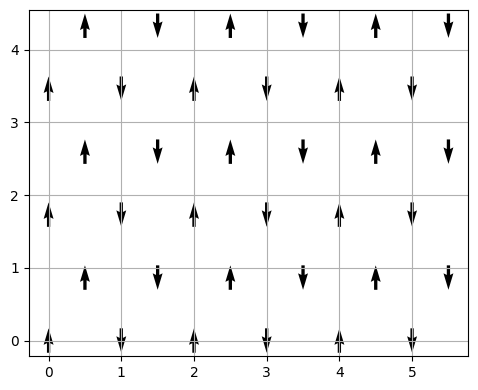

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
fac = 0.5

# ax.scatter(coords[:, 0], coords[:, 1])
ax.quiver(coords[:, 0], coords[:, 1], spin[:n_sites, 0], spin[:n_sites, 1], pivot='mid')
    
ax.grid()
ax.set_aspect('equal')
plt.tight_layout()

In [11]:
from ad_afqmc.spin_utils import get_ao_spin_average

Sx, Sy, Sz = get_ao_spin_average(gmf.mo_coeff, gmf.mo_occ)
spin = np.array(list(zip(Sx, Sz)))

sites = lattice.sites
coords = np.array([lattice.get_site_coordinate(site) for site in sites])

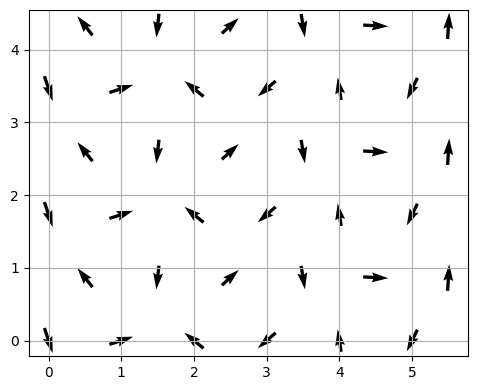

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
fac = 0.5

# ax.scatter(coords[:, 0], coords[:, 1])
ax.quiver(coords[:, 0], coords[:, 1], spin[:n_sites, 0], spin[:n_sites, 1], pivot='mid')
    
ax.grid()
ax.set_aspect('equal')
plt.tight_layout()